# Writing the next hit song
An exploratory analysis on maximising my chances of making the next hit song.  
Explore the Spotify dataset for features that may give me the edge on writing a popular song.  
  
Dataset: https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

In [276]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [277]:
DIR_DATA_RAW = os.path.join(".", "data", "external")

for dir, dirs, files in os.walk(DIR_DATA_RAW):
    for file in files:
        print(os.path.join(DIR_DATA_RAW, file))

.\data\external\artists.csv
.\data\external\data_by_artist_o.csv
.\data\external\data_by_genres_o.csv
.\data\external\data_by_year_o.csv
.\data\external\data_o.csv
.\data\external\dict_artists.json
.\data\external\tracks.csv


In [278]:
# Load data
df = pd.read_csv(os.path.join(DIR_DATA_RAW, 'tracks.csv'), index_col=0, parse_dates=['release_date'])

In [279]:
# Get a feel for the dataset
df

,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
id,,,,,,,,,,,,,,,,,,,
35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3
021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1
07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5
08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3
08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922-01-01,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5rgu12WBIHQtvej2MdHSH0,云与海,50,258267,0,['阿YueYue'],['1QLBXKM5GCpyQQSVMNZqrZ'],2020-09-26,0.560,0.5180,0,-7.471,0,0.0292,0.785,0.000000,0.0648,0.2110,131.896,4
0NuWgxEp51CutD2pJoF4OM,blind,72,153293,0,['ROLE MODEL'],['1dy5WNgIKQU6ezkpZs4y8z'],2020-10-21,0.765,0.6630,0,-5.223,1,0.0652,0.141,0.000297,0.0924,0.6860,150.091,4
27Y1N4Q4U3EfDU5Ubw8ws2,What They'll Say About Us,70,187601,0,['FINNEAS'],['37M5pPGs6V1fchFJSgCguX'],2020-09-02,0.535,0.3140,7,-12.823,0,0.0408,0.895,0.000150,0.0874,0.0663,145.095,4


In [280]:
YEARS_OF_DATA = 100
df = df[df.release_date > df.release_date.max() - pd.DateOffset(years=YEARS_OF_DATA)].sort_values(by='release_date', ascending=False)

In [281]:
df.describe()

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,586671.000000,5.866710e+05,586671.000000,586671.000000,586671.000000,586671.000000,586671.000000,586671.000000,586671.000000,586671.000000,586671.000000,586671.000000,586671.000000,586671.000000,586671.000000
mean,27.570067,2.300512e+05,0.044086,0.563594,0.542036,5.221608,-10.206076,0.658797,0.104864,0.449863,0.113451,0.213935,0.552292,118.464817,3.873382
std,18.370655,1.265262e+05,0.205286,0.166103,0.251923,3.519424,5.089328,0.474114,0.179893,0.348837,0.266868,0.184326,0.257671,29.764117,0.473163
min,0.000000,3.344000e+03,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13.000000,1.750930e+05,0.000000,0.453000,0.343000,2.000000,-12.891000,0.000000,0.034000,0.096900,0.000000,0.098300,0.346000,95.600000,4.000000
50%,27.000000,2.148930e+05,0.000000,0.577000,0.549000,5.000000,-9.243000,1.000000,0.044300,0.422000,0.000024,0.139000,0.564000,117.384000,4.000000
75%,41.000000,2.638670e+05,0.000000,0.686000,0.748000,8.000000,-6.482000,1.000000,0.076300,0.785000,0.009550,0.278000,0.769000,136.321000,4.000000
max,100.000000,5.621218e+06,1.000000,0.991000,1.000000,11.000000,5.376000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 586671 entries, 0DzTFqNNL2RukngVlkjbKA to 5CObFpQdx70P3mNR1WRjsu
Data columns (total 19 columns):
name                586600 non-null object
popularity          586671 non-null int64
duration_ms         586671 non-null int64
explicit            586671 non-null int64
artists             586671 non-null object
id_artists          586671 non-null object
release_date        586671 non-null datetime64[ns]
danceability        586671 non-null float64
energy              586671 non-null float64
key                 586671 non-null int64
loudness            586671 non-null float64
mode                586671 non-null int64
speechiness         586671 non-null float64
acousticness        586671 non-null float64
instrumentalness    586671 non-null float64
liveness            586671 non-null float64
valence             586671 non-null float64
tempo               586671 non-null float64
time_signature      586671 non-null int64
dtypes: datetime64[ns](1), fl

In [283]:
df.isnull().sum()

name                71
popularity           0
duration_ms          0
explicit             0
artists              0
id_artists           0
release_date         0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
dtype: int64

In [284]:
# see if there's anything interesting about NaN rows that might indicate larger problems with dataset
df.loc[df.name.isnull()]

,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
id,,,,,,,,,,,,,,,,,,,
1kR4gIb7nGxHPI3D2ifs59,NaN,26,289440,0,[''],['0LyfQWJT6nXafLPZqxe9Of'],1998-01-05,0.501,0.583,7,-9.460,0,0.0605,0.6900,0.003960,0.0747,0.734,138.391,4
4xyBq8t4nkUKH8s28j6ZoD,NaN,24,254000,0,[''],['0LyfQWJT6nXafLPZqxe9Of'],1998-01-05,0.390,0.452,7,-9.900,1,0.0361,0.7370,0.000000,0.1110,0.662,94.630,4
4iH7negBYMfj2z0wDNmgdx,NaN,28,264973,0,[''],['0LyfQWJT6nXafLPZqxe9Of'],1994-01-01,0.512,0.578,0,-12.280,0,0.0299,0.0433,0.000064,0.5160,0.692,156.465,1
0hKA9A2JPtFdg0fiMhyjQD,NaN,6,194081,0,[''],['0LyfQWJT6nXafLPZqxe9Of'],1974-12-31,0.471,0.369,4,-12.927,0,0.1460,0.9680,0.001100,0.1410,0.766,94.063,4
15RqFDA86slfzujSQMEX4i,NaN,2,257280,0,[''],['0LyfQWJT6nXafLPZqxe9Of'],1962-02-01,0.612,0.615,5,-5.609,1,0.0551,0.8540,0.000023,0.0541,0.809,90.536,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2DyOPZlmzeX1ksoU7xPfR9,NaN,0,193881,0,[''],['0LyfQWJT6nXafLPZqxe9Of'],1922-04-01,0.287,0.276,8,-16.278,1,0.0471,0.9940,0.030600,0.3490,0.512,67.967,3
1K6MQQxmFpPb66ZnaiIpHX,NaN,0,167602,0,[''],['0LyfQWJT6nXafLPZqxe9Of'],1922-04-01,0.558,0.283,1,-12.847,1,0.0646,0.9960,0.000000,0.4530,0.608,70.379,4
2DPL9XgEjygqmZvqeaIA8L,NaN,0,179907,0,[''],['0LyfQWJT6nXafLPZqxe9Of'],1922-04-01,0.441,0.146,3,-12.692,0,0.0780,0.9950,0.585000,0.1720,0.515,67.431,4


In [285]:
#no larger issues identified - drop rows
df.dropna(inplace=True)

# drop rows with time_signature as 0
df = df[df.time_signature != 0]
df.describe()['time_signature']['min']

# duration in seconds
df['duration_ms'] = df.duration_ms/1.0e3
df.rename(columns = {'duration_ms': 'duration_s'}, inplace=True)
dtypes = df.dtypes.value_counts()

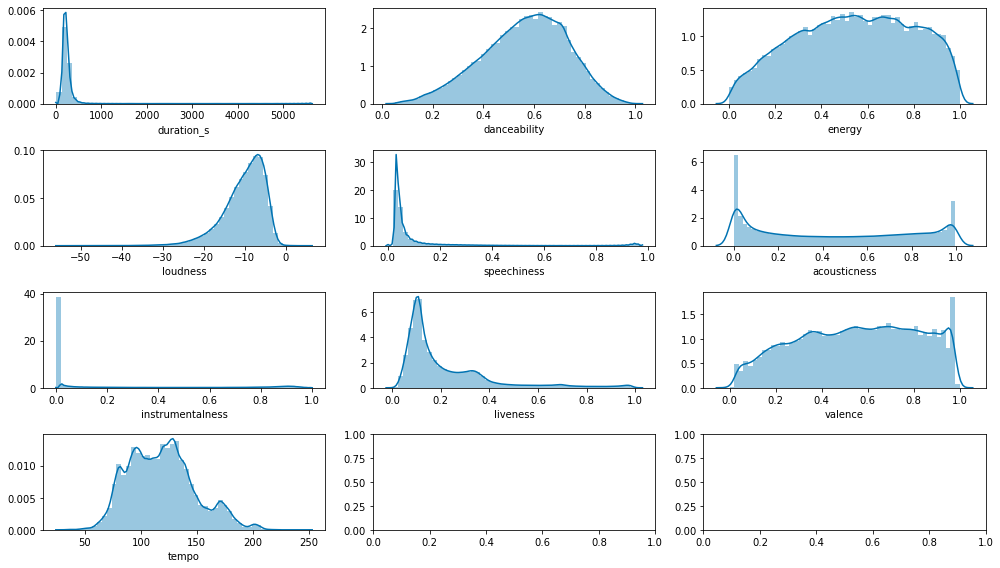

In [286]:
y = ['popularity']
cols_numerical = ['duration_s', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
cols_categorical = ['explicit', 'release_date', 'key', 'mode', 'time_signature']

# create 3 column grid (may be a few spare plots in the final row)
cols = 3
rows = int(np.ceil(1.0*len(cols_numerical)/3))
figure, axes = plt.subplots(rows, cols, figsize=(14,8)) 

i = 0
j = 0
for col in cols_numerical:
    sns.distplot(df[col], ax=axes[i, j]) 
    j += 1 # next column
    if(j >= cols): # if we would next plot at column 4, move to first column in the next row
        i += 1
        j = 0

figure.tight_layout() # fix spacing issues

In [287]:
%%HTML
Top 10 tracks in key of C minor

In [288]:
df[(df['key'] == 0) & (df['mode'] == 0)].sort_values('popularity', ascending=False)[['name', 'artists', 'popularity', 'key', 'mode']].head(10)

,name,artists,popularity,key,mode
id,,,,,
3iw6V4LH7yPj1ESORX9RIN,Wellerman - Sea Shanty / 220 KID x Billen Ted ...,"['Nathan Evans', '220 KID', 'Billen Ted']",92,0,0
3aQem4jVGdhtg116TmJnHz,What’s Next,['Drake'],91,0,0
21N4Buj4xsyLb218lYle61,Chica Ideal,"['Sebastian Yatra', 'Guaynaa']",87,0,0
1xQ6trAsedVPCdbtDAmk0c,Savage Love (Laxed - Siren Beat),"['Jawsh 685', 'Jason Derulo']",87,0,0
7fBv7CLKzipRk6EC6TWHOB,The Hills,['The Weeknd'],87,0,0
7m9OqQk4RVRkw9JJdeAw96,Jocelyn Flores,['XXXTENTACION'],87,0,0
1IIKrJVP1C9N7iPtG6eOsK,Go Crazy,"['Chris Brown', 'Young Thug']",85,0,0
3dhjNA0jGA8vHBQ1VdD6vV,I Feel It Coming,"['The Weeknd', 'Daft Punk']",84,0,0
7AQim7LbvFVZJE3O8TYgf2,Fuck Love (feat. Trippie Redd),"['XXXTENTACION', 'Trippie Redd']",84,0,0


In [289]:
# Top 3 most popular solo artists
# does not account for solo + collaborations; accounts for solo releases only
a = df.copy()
a = df.groupby('artists').mean().sort_values(by='popularity', ascending=False)
a['num_artists'] = [len(x.split(', ')) for x in a.index]
a[a['num_artists'] == 1].head(3)

,popularity,duration_s,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,num_artists
artists,,,,,,,,,,,,,,,,
['Regard'],87.0,157.606,0.0,0.880,0.751,7.0,-4.258,0.0,0.0874,0.1770,0.000064,0.1060,0.884,117.948,4.0,1
['Ritt Momney'],87.0,210.463,0.0,0.399,0.491,6.0,-10.778,0.0,0.0538,0.0563,0.000890,0.1100,0.151,91.066,4.0,1
['ElyOtto'],87.0,80.081,1.0,0.748,0.734,0.0,-6.499,1.0,0.1240,0.5240,0.000012,0.0975,0.368,97.753,4.0,1


In [290]:
df_corr = df[cols_numerical + y].corr() # correlation coefficients don't make sense for categorical columns

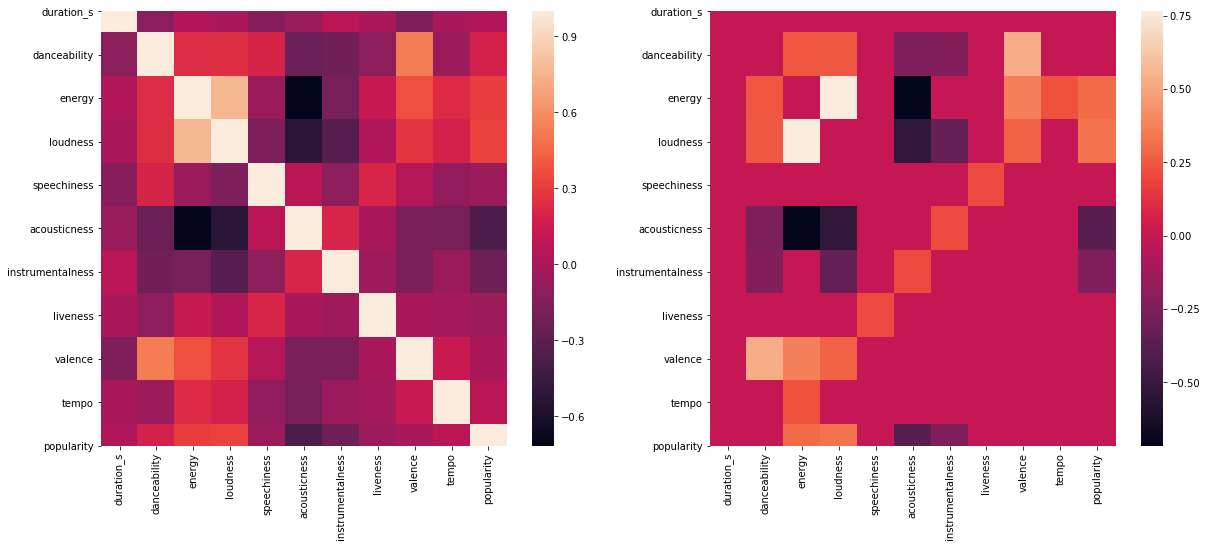

In [291]:
CORRELATION_THRESH = 0.2  # arbitrary correlation threshold (0 to 1) to 
highly_correlated_indices = np.multiply(df_corr.abs() > CORRELATION_THRESH, df_corr.abs() != 1)  
# .abs() to account for negatively-correlated entries
# !=1 to remove the main diagonal (entries are, of course, perfectly correlated with themselves) 

np.multiply(highly_correlated_indices, df_corr).style.background_gradient(cmap='viridis')
# energy and loudness are highly correlated - drop loudness or energy to avoid highly correlated columns disproportionately effecting results
f, a = plt.subplots(1,2, figsize=(20,8));
plt.subplot(1,2,1)
sns.heatmap(df_corr);
a[0].title.set_text('Correlation coefficients of numerical data')

plt.subplot(1,2,2)
sns.heatmap(np.multiply(highly_correlated_indices, df_corr));


In [292]:
# but what makes a song popular?
df_corr['popularity'].drop('popularity').sort_values(ascending=False) # look at popularity column and remove entry w.r.t. itself


loudness            0.328544
energy              0.302883
danceability        0.187797
tempo               0.071843
duration_s          0.027453
valence             0.004712
speechiness        -0.047399
liveness           -0.048920
instrumentalness   -0.237244
acousticness       -0.370964
Name: popularity, dtype: float64

In [293]:
# energy is highly correlated with loudness, but is less correlated with popularity than loudness, so drop energy
cols_numerical.remove('energy')
df.drop(['energy'], axis=1, inplace=True)


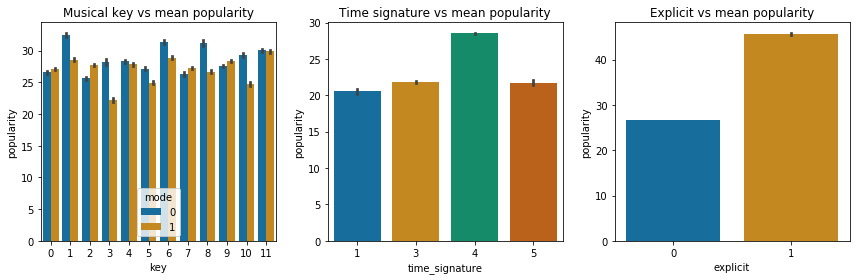

In [294]:
# explore attributes that contain discrete data
rows = 1
cols = 3
f, a = plt.subplots(rows,cols, figsize=(12,4))

sns.set_palette('colorblind')
plt.subplot(rows,cols,1)
plt.title('Musical key vs mean popularity')
sns.barplot(x='key', y='popularity', hue='mode', data=df)

plt.subplot(rows,cols,2)
plt.title('Time signature vs mean popularity')
sns.barplot(x='time_signature', y='popularity', data=df);

plt.subplot(rows,cols,3)
plt.title('Explicit vs mean popularity')
sns.barplot(x='explicit', y='popularity', data=df);

plt.tight_layout()

In [295]:
df['year'] = [x.year for x in df.release_date]
df[['year','release_date']]

,year,release_date
id,,
0DzTFqNNL2RukngVlkjbKA,2021,2021-04-16
2romdyQNQM3AYoNWLc12wD,2021,2021-04-16
6ILjkEufgyZ7NyLnrpr6zr,2021,2021-04-16
3MXopdUtwhQPxDOdj39oDA,2021,2021-04-16
1isEADg1EJ9dqQUjsHjOhS,2021,2021-04-16
...,...,...
4yTwNqT53nEaIMMxDsnNr3,1922,1922-01-01
0wG1anJSasIRZ8wu9vvYOC,1922,1922-01-01
12VN7yyLDADH7k5BJbyO3j,1922,1922-01-01


In [296]:
tracks_by_year = df.groupby('year').mean()
tracks_by_year = tracks_by_year.sort_values('year')
tracks_by_year.drop(['explicit', 'key', 'mode', 'time_signature'], axis=1, inplace=True)  # doesn't make sense to use mean value of these fields
tracks_by_year

,popularity,duration_s,danceability,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
year,,,,,,,,,,
1922,0.057971,165.202185,0.541207,-14.073036,0.258699,0.892674,0.328275,0.246547,0.572387,110.133703
1923,1.575342,156.975915,0.637332,-16.351921,0.552072,0.859965,0.157659,0.225396,0.671967,109.552648
1924,0.614286,189.324175,0.596170,-13.250265,0.376995,0.865648,0.337091,0.203493,0.557578,120.026741
1925,1.433221,191.870484,0.625706,-14.371232,0.309810,0.924455,0.279093,0.258593,0.643751,115.435071
1926,1.938776,165.946540,0.622113,-15.929906,0.356952,0.785739,0.323416,0.211447,0.539702,113.386792
...,...,...,...,...,...,...,...,...,...,...
2017,42.198397,230.009912,0.626874,-7.145313,0.100823,0.277536,0.087672,0.200527,0.495469,121.704836
2018,42.133736,220.945919,0.635614,-7.367837,0.108401,0.277820,0.097669,0.198078,0.484092,121.895834
2019,44.916758,217.029603,0.651146,-7.405970,0.111412,0.293356,0.080572,0.189986,0.495293,122.290781


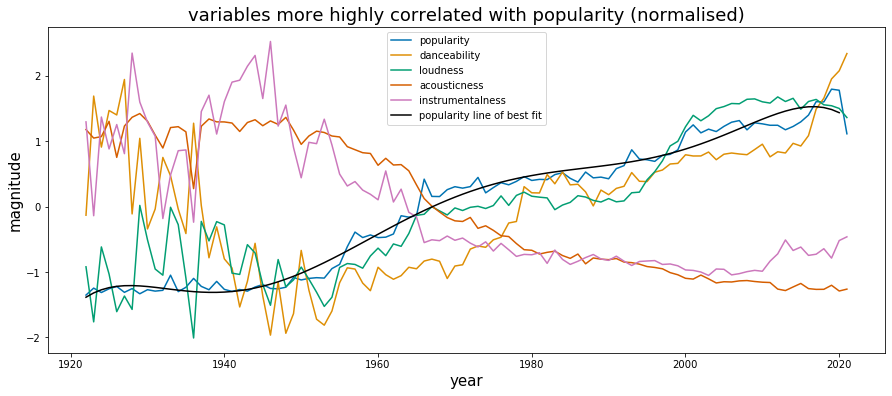

In [297]:
# filter out low correlation noise
tracks_by_year_normalised = tracks_by_year.copy()
CORRELATION_THRESH = 0.1 

# normalise variables to improve readibility from graph
for col in tracks_by_year.columns:  
    mean = tracks_by_year[col].mean()
    std_dev = tracks_by_year[col].std()
    tracks_by_year_normalised[col] = (tracks_by_year[col] - mean)/std_dev
    
# create plot
figure, axes = plt.subplots(figsize=(15,6));
l = []  # initiate list for legend
for col in tracks_by_year_normalised.columns:  # plot if correlated enough with popularity
    if(df_corr['popularity'].abs()[col] > CORRELATION_THRESH):
        sns.lineplot(x=tracks_by_year_normalised.index, y=col, data=tracks_by_year_normalised)
        l.append(col)

#  looks like at least 4 local minima and maxima on popularity curve
#  choose 5th degree polynomial or greater
d = 6  # polynomial degree
curve = np.poly1d(np.polyfit(tracks_by_year_normalised.index, tracks_by_year_normalised.popularity, d));  # get poly coefficients
x = range(tracks_by_year.index.min(), tracks_by_year.index.max());  # create array of integers from start year to end year
plt.plot(x, curve(x), color='black')  # overlay best fit curve with calculated (x, curve(x))

l.append('popularity line of best fit')
plt.legend(labels=l);
axes.set_ylabel('magnitude', fontsize=15);
axes.set_xlabel('year', fontsize=15);
axes.set_title('variables more highly correlated with popularity (normalised)', fontsize=18);


# Conclusion

## To maximise chances at writing a pop hit, write a song:
- in one of the following keys: C#, F# or G# minor
- in 4/4 time
- that you can dance to (and turn up the volume)
- include some explicit language
- must not be purely instrumental or accoustic 
